In [1]:
import pandas as pd

In [2]:
PATH = 'data/d.csv'

In [3]:
csv = pd.read_csv(PATH)

In [4]:
csv

,plant.ID,y,alpha
0,1,0,-4.159582
1,2,0,-3.718362
2,3,0,-3.069020
3,4,0,-3.054211
4,5,0,-2.880656
5,6,2,-2.705595
6,7,1,-2.441703
7,8,1,-2.221327
8,9,0,-2.209120
9,10,1,-2.111941


In [5]:
ys = csv['y'].values

In [6]:
import numpy as np

histo_ys = np.zeros(11)
for y in ys:
    histo_ys[y] += 1
print(histo_ys)
print(np.sum(histo_ys))

[  7.  10.  10.   5.  12.  11.  11.   7.  14.   9.   4.]
100.0


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

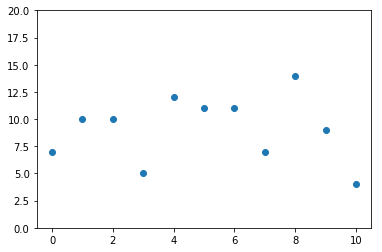

In [8]:
xs = np.arange(11)
plt.scatter(xs, histo_ys)
plt.ylim(0, 20)
plt.show()

In [9]:
import pymc3 as pm

In [10]:
ys

array([ 0,  0,  0,  0,  0,  2,  1,  1,  0,  1,  2,  2,  1,  1,  4,  1,  1,
        1,  1,  2,  4,  2,  2,  6,  2,  3,  0,  3,  6,  5,  2,  4,  1,  5,
        5,  3,  4,  4,  3,  5,  2,  3,  5,  6,  4,  4,  5,  2,  6,  6,  8,
        4,  6,  5,  5,  7,  4,  6,  4,  5,  5,  4,  6,  7,  4,  5,  6, 10,
        9, 10,  8,  7,  8,  6,  8,  8,  8,  9,  9,  8,  9,  7,  8,  7,  7,
        8,  8,  9,  8,  9,  9,  9,  8,  7,  6,  8,  8,  9, 10, 10])

In [11]:
model = pm.Model()
with model:
    q = pm.Uniform('q', lower=0, upper=1)
    y = pm.Binomial('y', n=10, p=q, observed=ys)
    map_estimate = pm.find_MAP(model=model)

logp = -316.78, ||grad|| = 4: 100%|██████████| 5/5 [00:00<00:00, 61.75it/s]


In [12]:
print((float(map_estimate['q'])))

0.4960000053023121


In [13]:
import scipy

In [17]:
rv = scipy.stats.binom(10, map_estimate['q'])
binom_ys = [100 * rv.pmf(k) for k in range(11)]

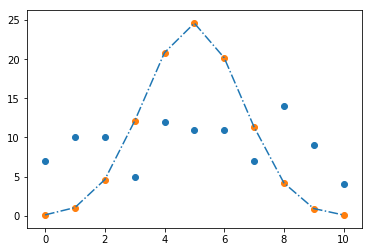

In [22]:
plt.scatter(xs, histo_ys)
plt.plot(xs, binom_ys, ls='-.')
plt.scatter(xs, binom_ys)
plt.show()

In [29]:
model = pm.Model()
with model:
    beta = pm.Uniform('beta', lower=-0.5, upper=0.5)
    sigma = pm.Uniform('sigma', lower=1, upper=2)
    alpha = pm.Normal('alpha', mu=0, sd=sigma)
    ymu = pm.math.sigmoid(beta + alpha)
    y = pm.Binomial('y', n=10, p=ymu, observed=ys)
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(2000, step=step, start=start)
    

logp = -317.67, ||grad|| = 0.0058024: 100%|██████████| 35/35 [00:00<00:00, 1740.35it/s]  
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, sigma, beta]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:04<00:00, 2148.00draws/s]
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c241539b0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c24250860>]], dtype=object)

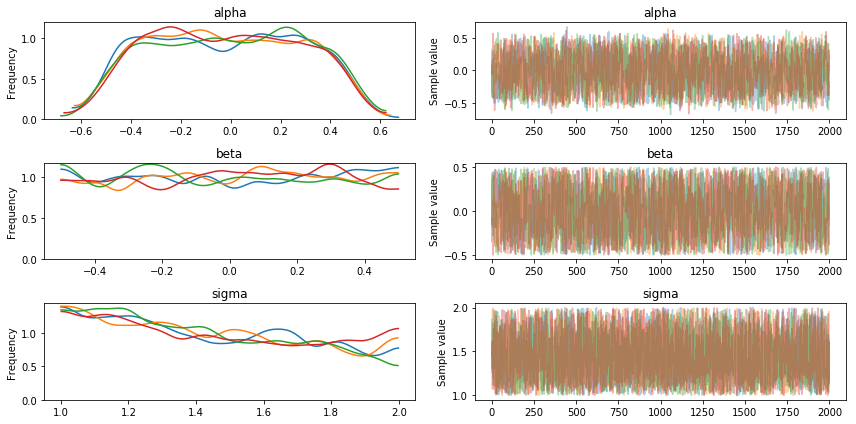

In [31]:
pm.traceplot(trace)

In [32]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-0.02,0.29,0.01,-0.52,0.48,1983.56,1.0
beta,0.00,0.29,0.01,-0.50,0.45,1944.77,1.0
sigma,1.45,0.29,0.00,1.00,1.94,3790.55,1.0


In [38]:
beta_samples = trace['beta'][:]
print(type(beta_samples), beta_samples.shape)
alpha_samples = trace['alpha'][:]
print(type(alpha_samples), alpha_samples.shape)

<class 'numpy.ndarray'> (8000,)
<class 'numpy.ndarray'> (8000,)


In [41]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

In [42]:
 ymu_samples = sigmoid(beta_samples + alpha_samples)

In [43]:
ymu_samples.shape

(8000,)

In [45]:
ymu_samples.mean()

0.4961397526149916